In [62]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one, solve_smooth
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

$$
\begin{aligned}
0 = \max_{\mathcal{E}} & - \delta \phi(y) + \delta \eta log(\mathcal{E}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \theta \mathcal{E}) \\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathcal{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$

$$
\mathcal{E}^* = -\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}
$$

$$
\begin{aligned}
0 = & - \delta \phi(y) + \delta \eta log(-\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 )  - \delta \eta\\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathcal{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$

In [2]:
# parameters
δ = 0.01
η = 0.032
ξₐ = 1/4000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
θ = np.mean(θ_list)
σy = 1.2*θ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.array([0, 2*0.0197, 2*0.3853])
# y grid
numy_bar = 100
y_min = 0
y_max = 4
hy = (ȳ - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)

In [33]:
y1_grid = np.linspace(0, 4, 50)
y2_grid = np.linspace(0, 1, 50)
# mesh grid and construct state space
(y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
hy1 = y1_grid[1] - y1_grid[0]
hy2 = y2_grid[1] - y2_grid[0]

In [34]:
π_p = np.array([1, 0, 0])
dΛ1 = γ1 + γ2*y1_mat + π_p@γ3_list*(y1_mat - ȳ)*(y1_mat >ȳ)
dΛ2 = γ1 + γ2*y2_mat + π_p@γ3_list*(y2_mat - ȳ)*(y2_mat >ȳ)
# ddΛ = γ2 + π_p@γ3_list*(y_mat >ȳ)
λ = np.log(2)/6
tol = 1e-7

In [35]:
ems_new = δ*η
ems_old = ems_new
ϵ = 1
episode = 0
lhs_error = 0.5
max_iter = 5_000
while lhs_error > tol:
    if episode ==0:
        v0 =  - y2_mat**2
    else:
        vold = v0.copy()
    v0_dy1 = derivatives_2d(v0,0,1,hy1)
#     v0_dyy1 = derivatives_2d(v0,0,2,hy1)
    v0_dy2 = derivatives_2d(v0,1,1,hy2)
    v0_dy2[v0_dy2 > - 1e-15] =  - 1e-15
#     v0_dyy2 = derivatives_2d(v0,1,2,hy2)
    # updating controls
    ems_new =  - δ*η/(v0_dy2*λ*θ)
#     ems_new[ems_new <= 1e-15] = 1e-15
    ems = ems_new*1 + ems_old*0.
    print(np.min(ems))
    # HJB coefficient
    A =  -δ*np.ones(y1_mat.shape)
    B_y1 =  y2_mat
    B_y2 = - λ*y2_mat
    C_yy1 = np.zeros(y1_mat.shape)
    C_yy2 = np.zeros(y1_mat.shape)
    D = δ*η*np.log(ems) +  (η-1)*dΛ1*y2_mat - δ*η
    # PDE solver
    solve_start = time.time()
    out = PDESolver_2d(stateSpace, A, B_y1, B_y2, C_yy1, C_yy2, D, v0, ϵ, solverType = 'False Transient')
    out_comp = out[2].reshape(v0.shape,order = "F")
    rhs = A*v0 + B_y1*v0_dy1 + B_y2*v0_dy2  + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((out_comp - v0)/ϵ))
    #     if episode % 1 == 0:
    print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    episode += 1
    v0 = out_comp
    ems_old = ems
    print("End of PDE solver, takes time: {}".format(time.time() - solve_start))

0.7515056127811689
Episode 0: PDE Error: 0.238108906203; False Transient Error: 0.188964399019; Iterations: 718; CG Error: 0.000000000100
End of PDE solver, takes time: 0.020029783248901367
0.91920320454367
Episode 1: PDE Error: 0.189031863107; False Transient Error: 0.149751509825; Iterations: 718; CG Error: 0.000000000089
End of PDE solver, takes time: 0.02076864242553711
1.1152481044777363
Episode 2: PDE Error: 0.149817297943; False Transient Error: 0.118450138282; Iterations: 718; CG Error: 0.000000000090
End of PDE solver, takes time: 0.020958662033081055
1.3396558581412261
Episode 3: PDE Error: 0.118513770064; False Transient Error: 0.093491398039; Iterations: 718; CG Error: 0.000000000081
End of PDE solver, takes time: 0.021105527877807617
1.5900884487294848
Episode 4: PDE Error: 0.093552325073; False Transient Error: 0.073614174535; Iterations: 717; CG Error: 0.000000000092
End of PDE solver, takes time: 0.020453929901123047
1.8613421325891533
Episode 5: PDE Error: 0.0736717985

Episode 51: PDE Error: 0.000387387858; False Transient Error: 0.000378185802; Iterations: 696; CG Error: 0.000000000086
End of PDE solver, takes time: 0.01940155029296875
3.4321875055916693
Episode 52: PDE Error: 0.000380450626; False Transient Error: 0.000371525371; Iterations: 696; CG Error: 0.000000000086
End of PDE solver, takes time: 0.019257545471191406
3.427792359572225
Episode 53: PDE Error: 0.000373689382; False Transient Error: 0.000365031691; Iterations: 696; CG Error: 0.000000000083
End of PDE solver, takes time: 0.01916813850402832
3.423578845507379
Episode 54: PDE Error: 0.000367096890; False Transient Error: 0.000358697954; Iterations: 695; CG Error: 0.000000000100
End of PDE solver, takes time: 0.019285202026367188
3.4195330526116994
Episode 55: PDE Error: 0.000360666383; False Transient Error: 0.000352517802; Iterations: 695; CG Error: 0.000000000098
End of PDE solver, takes time: 0.019275188446044922
3.415642494859183
Episode 56: PDE Error: 0.000354391529; False Trans

Episode 95: PDE Error: 0.000194488464; False Transient Error: 0.000192562835; Iterations: 692; CG Error: 0.000000000091
End of PDE solver, takes time: 0.019394397735595703
3.322215193841511
Episode 96: PDE Error: 0.000191784162; False Transient Error: 0.000189885308; Iterations: 692; CG Error: 0.000000000091
End of PDE solver, takes time: 0.019138813018798828
3.3206906075089715
Episode 97: PDE Error: 0.000189122750; False Transient Error: 0.000187250246; Iterations: 692; CG Error: 0.000000000094
End of PDE solver, takes time: 0.019089460372924805
3.3191892549711164
Episode 98: PDE Error: 0.000186503361; False Transient Error: 0.000184656792; Iterations: 692; CG Error: 0.000000000090
End of PDE solver, takes time: 0.0192108154296875
3.317710616088303
Episode 99: PDE Error: 0.000183925156; False Transient Error: 0.000182104114; Iterations: 692; CG Error: 0.000000000088
End of PDE solver, takes time: 0.01926445960998535
3.3162541952207936
Episode 100: PDE Error: 0.000181387318; False Tran

Episode 139: PDE Error: 0.000107165454; False Transient Error: 0.000106104409; Iterations: 688; CG Error: 0.000000000098
End of PDE solver, takes time: 0.019398927688598633
3.272261392456296
Episode 140: PDE Error: 0.000105761784; False Transient Error: 0.000104714637; Iterations: 689; CG Error: 0.000000000089
End of PDE solver, takes time: 0.02241802215576172
3.2714449757592923
Episode 141: PDE Error: 0.000104377724; False Transient Error: 0.000103344280; Iterations: 688; CG Error: 0.000000000097
End of PDE solver, takes time: 0.019140243530273438
3.2706396009967325
Episode 142: PDE Error: 0.000103012961; False Transient Error: 0.000101993030; Iterations: 688; CG Error: 0.000000000098
End of PDE solver, takes time: 0.019055843353271484
3.2698451081970905
Episode 143: PDE Error: 0.000101667187; False Transient Error: 0.000100660580; Iterations: 688; CG Error: 0.000000000092
End of PDE solver, takes time: 0.019489765167236328
3.2690613400420054
Episode 144: PDE Error: 0.000100340096; Fa

Episode 183: PDE Error: 0.000060458939; False Transient Error: 0.000059860334; Iterations: 684; CG Error: 0.000000000096
End of PDE solver, takes time: 0.019250869750976562
3.2449743170254486
Episode 184: PDE Error: 0.000059683468; False Transient Error: 0.000059092541; Iterations: 684; CG Error: 0.000000000096
End of PDE solver, takes time: 0.019018888473510742
3.2445213236017603
Episode 185: PDE Error: 0.000058918005; False Transient Error: 0.000058334657; Iterations: 684; CG Error: 0.000000000096
End of PDE solver, takes time: 0.018985509872436523
3.2440742689425037
Episode 186: PDE Error: 0.000058162409; False Transient Error: 0.000057586542; Iterations: 684; CG Error: 0.000000000092
End of PDE solver, takes time: 0.018972158432006836
3.2436330722184366
Episode 187: PDE Error: 0.000057416545; False Transient Error: 0.000056848063; Iterations: 684; CG Error: 0.000000000092
End of PDE solver, takes time: 0.018836021423339844
3.2431976538051233
Episode 188: PDE Error: 0.000056680280; 

Episode 227: PDE Error: 0.000034258630; False Transient Error: 0.000033919438; Iterations: 681; CG Error: 0.000000000086
End of PDE solver, takes time: 0.019071578979492188
3.2297319049351922
Episode 228: PDE Error: 0.000033819032; False Transient Error: 0.000033484192; Iterations: 681; CG Error: 0.000000000085
End of PDE solver, takes time: 0.01878046989440918
3.22947711643003
Episode 229: PDE Error: 0.000033385074; False Transient Error: 0.000033054530; Iterations: 680; CG Error: 0.000000000093
End of PDE solver, takes time: 0.01889324188232422
3.229225611638261
Episode 230: PDE Error: 0.000032956687; False Transient Error: 0.000032630384; Iterations: 680; CG Error: 0.000000000093
End of PDE solver, takes time: 0.018883705139160156
3.228977349099622
Episode 231: PDE Error: 0.000032533799; False Transient Error: 0.000032211682; Iterations: 680; CG Error: 0.000000000094
End of PDE solver, takes time: 0.018888473510742188
3.2287322858247705
Episode 232: PDE Error: 0.000032116339; False 

Episode 271: PDE Error: 0.000019409055; False Transient Error: 0.000019216886; Iterations: 676; CG Error: 0.000000000095
End of PDE solver, takes time: 0.019225597381591797
3.221127795446289
Episode 272: PDE Error: 0.000019160010; False Transient Error: 0.000018970307; Iterations: 676; CG Error: 0.000000000097
End of PDE solver, takes time: 0.019089221954345703
3.220983430919792
Episode 273: PDE Error: 0.000018914156; False Transient Error: 0.000018726886; Iterations: 675; CG Error: 0.000000000098
End of PDE solver, takes time: 0.018835783004760742
3.220840907316061
Episode 274: PDE Error: 0.000018671455; False Transient Error: 0.000018486588; Iterations: 675; CG Error: 0.000000000098
End of PDE solver, takes time: 0.018896818161010742
3.220700206559773
Episode 275: PDE Error: 0.000018431864; False Transient Error: 0.000018249369; Iterations: 675; CG Error: 0.000000000095
End of PDE solver, takes time: 0.018769264221191406
3.2205613021270327
Episode 276: PDE Error: 0.000018195344; Fals

Episode 314: PDE Error: 0.000011135787; False Transient Error: 0.000011025530; Iterations: 670; CG Error: 0.000000000094
End of PDE solver, takes time: 0.02030467987060547
3.2163261522902804
Episode 315: PDE Error: 0.000010992746; False Transient Error: 0.000010883905; Iterations: 670; CG Error: 0.000000000093
End of PDE solver, takes time: 0.021397829055786133
3.216242963523218
Episode 316: PDE Error: 0.000010851538; False Transient Error: 0.000010744095; Iterations: 670; CG Error: 0.000000000092
End of PDE solver, takes time: 0.021880626678466797
3.216160831747622
Episode 317: PDE Error: 0.000010712138; False Transient Error: 0.000010606076; Iterations: 670; CG Error: 0.000000000089
End of PDE solver, takes time: 0.021596908569335938
3.2160797435437267
Episode 318: PDE Error: 0.000010574525; False Transient Error: 0.000010469825; Iterations: 670; CG Error: 0.000000000088
End of PDE solver, takes time: 0.02098703384399414
3.2159996855691135
Episode 319: PDE Error: 0.000010438676; Fals

Episode 357: PDE Error: 0.000011204120; False Transient Error: 0.000006320833; Iterations: 667; CG Error: 0.000000000083
End of PDE solver, takes time: 0.018740177154541016
3.213556123915412
Episode 358: PDE Error: 0.000011264663; False Transient Error: 0.000006239500; Iterations: 667; CG Error: 0.000000000082
End of PDE solver, takes time: 0.018468856811523438
3.2135080746404263
Episode 359: PDE Error: 0.000011324425; False Transient Error: 0.000006159211; Iterations: 667; CG Error: 0.000000000083
End of PDE solver, takes time: 0.018616676330566406
3.2134606340683516
Episode 360: PDE Error: 0.000011383417; False Transient Error: 0.000006079946; Iterations: 666; CG Error: 0.000000000099
End of PDE solver, takes time: 0.01853466033935547
3.2134137933891735
Episode 361: PDE Error: 0.000011441646; False Transient Error: 0.000006001707; Iterations: 667; CG Error: 0.000000000081
End of PDE solver, takes time: 0.018399715423583984
3.213367547934331
Episode 362: PDE Error: 0.000011499128; Fal

Episode 401: PDE Error: 0.000013246714; False Transient Error: 0.000003572903; Iterations: 663; CG Error: 0.000000000099
End of PDE solver, takes time: 0.018596887588500977
3.2119274585923714
Episode 402: PDE Error: 0.000013280903; False Transient Error: 0.000003526819; Iterations: 664; CG Error: 0.000000000083
End of PDE solver, takes time: 0.018517255783081055
3.2119000251452436
Episode 403: PDE Error: 0.000013314652; False Transient Error: 0.000003481330; Iterations: 664; CG Error: 0.000000000083
End of PDE solver, takes time: 0.018502473831176758
3.2118729380547046
Episode 404: PDE Error: 0.000013347964; False Transient Error: 0.000003436427; Iterations: 663; CG Error: 0.000000000094
End of PDE solver, takes time: 0.01850152015686035
3.2118461927780477
Episode 405: PDE Error: 0.000013380845; False Transient Error: 0.000003392098; Iterations: 663; CG Error: 0.000000000094
End of PDE solver, takes time: 0.018354415893554688
3.2118197863418163
Episode 406: PDE Error: 0.000013413302; F

Episode 445: PDE Error: 0.000014399546; False Transient Error: 0.000002016598; Iterations: 660; CG Error: 0.000000000099
End of PDE solver, takes time: 0.01905965805053711
3.210997261230099
Episode 446: PDE Error: 0.000014418824; False Transient Error: 0.000001990509; Iterations: 661; CG Error: 0.000000000084
End of PDE solver, takes time: 0.01839590072631836
3.2109815860624606
Episode 447: PDE Error: 0.000014437857; False Transient Error: 0.000001964760; Iterations: 661; CG Error: 0.000000000084
End of PDE solver, takes time: 0.018404722213745117
3.210966108158809
Episode 448: PDE Error: 0.000014456642; False Transient Error: 0.000001939343; Iterations: 661; CG Error: 0.000000000084
End of PDE solver, takes time: 0.018342256546020508
3.2109508254792614
Episode 449: PDE Error: 0.000014475183; False Transient Error: 0.000001914255; Iterations: 660; CG Error: 0.000000000094
End of PDE solver, takes time: 0.018262863159179688
3.2109357345854055
Episode 450: PDE Error: 0.000014493481; Fals

Episode 489: PDE Error: 0.000015049159; False Transient Error: 0.000001136120; Iterations: 657; CG Error: 0.000000000099
End of PDE solver, takes time: 0.018364667892456055
3.2104639866954545
Episode 490: PDE Error: 0.000015060012; False Transient Error: 0.000001121381; Iterations: 602; CG Error: 0.000000000099
End of PDE solver, takes time: 0.01685929298400879
3.210454159225271
Episode 491: PDE Error: 0.000015070723; False Transient Error: 0.000001106819; Iterations: 657; CG Error: 0.000000000099
End of PDE solver, takes time: 0.018090486526489258
3.2104443202002764
Episode 492: PDE Error: 0.000015081297; False Transient Error: 0.000001092456; Iterations: 598; CG Error: 0.000000000096
End of PDE solver, takes time: 0.016991376876831055
3.210435905508976
Episode 493: PDE Error: 0.000015091733; False Transient Error: 0.000001078273; Iterations: 598; CG Error: 0.000000000092
End of PDE solver, takes time: 0.016600370407104492
3.2104282705076383
Episode 494: PDE Error: 0.000015102033; Fal

Episode 537: PDE Error: 0.000015438402; False Transient Error: 0.000000606045; Iterations: 594; CG Error: 0.000000000099
End of PDE solver, takes time: 0.016864538192749023
3.210137896665318
Episode 538: PDE Error: 0.000015444188; False Transient Error: 0.000000598147; Iterations: 593; CG Error: 0.000000000089
End of PDE solver, takes time: 0.016562938690185547
3.2101314464014994
Episode 539: PDE Error: 0.000015449894; False Transient Error: 0.000000590349; Iterations: 592; CG Error: 0.000000000098
End of PDE solver, takes time: 0.016401290893554688
3.210126511827283
Episode 540: PDE Error: 0.000015455527; False Transient Error: 0.000000582649; Iterations: 596; CG Error: 0.000000000099
End of PDE solver, takes time: 0.016495466232299805
3.2101233862359755
Episode 541: PDE Error: 0.000015461087; False Transient Error: 0.000000575049; Iterations: 652; CG Error: 0.000000000089
End of PDE solver, takes time: 0.018070697784423828
3.2101222059345926
Episode 542: PDE Error: 0.000015466574; Fa

Episode 585: PDE Error: 0.000015645551; False Transient Error: 0.000000322287; Iterations: 589; CG Error: 0.000000000099
End of PDE solver, takes time: 0.016677379608154297
3.2099571770850543
Episode 586: PDE Error: 0.000015648623; False Transient Error: 0.000000318065; Iterations: 649; CG Error: 0.000000000085
End of PDE solver, takes time: 0.018009662628173828
3.209957809000116
Episode 587: PDE Error: 0.000015651655; False Transient Error: 0.000000313895; Iterations: 649; CG Error: 0.000000000087
End of PDE solver, takes time: 0.01797628402709961
3.2099586758629624
Episode 588: PDE Error: 0.000015654646; False Transient Error: 0.000000309781; Iterations: 592; CG Error: 0.000000000096
End of PDE solver, takes time: 0.016439199447631836
3.2099583535697915
Episode 589: PDE Error: 0.000015657598; False Transient Error: 0.000000305715; Iterations: 645; CG Error: 0.000000000089
End of PDE solver, takes time: 0.017745018005371094
3.2099577615992994
Episode 590: PDE Error: 0.000015660513; Fa

Episode 635: PDE Error: 0.000015758634; False Transient Error: 0.000000166281; Iterations: 526; CG Error: 0.000000000098
End of PDE solver, takes time: 0.015510797500610352
3.209868084997709
Episode 636: PDE Error: 0.000015760217; False Transient Error: 0.000000172200; Iterations: 590; CG Error: 0.000000000097
End of PDE solver, takes time: 0.016691923141479492
3.2098665177084067
Episode 637: PDE Error: 0.000015761777; False Transient Error: 0.000000161918; Iterations: 585; CG Error: 0.000000000100
End of PDE solver, takes time: 0.016992807388305664
3.2098624681543195
Episode 638: PDE Error: 0.000015763323; False Transient Error: 0.000000159788; Iterations: 517; CG Error: 0.000000000094
End of PDE solver, takes time: 0.01490330696105957
3.209857814744515
Episode 639: PDE Error: 0.000015764838; False Transient Error: 0.000000157677; Iterations: 453; CG Error: 0.000000000098
End of PDE solver, takes time: 0.013055801391601562
3.2098547840203846
Episode 640: PDE Error: 0.000015766352; Fal

In [36]:
n_y1 = len(y1_grid)
n_y2 = len(y2_grid)

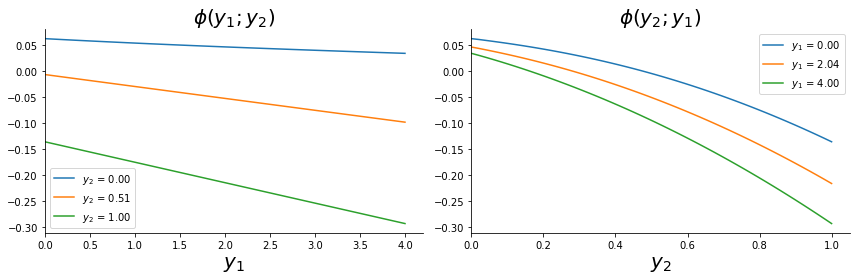

In [37]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat[:,0], v0[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat[:,0], v0[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat[:,0], v0[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$ϕ(y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.legend()
# ax1.tick_params(labelsize=20)
ax1.set_xlim(0)
# ax1.set_ylim(-0.18, 0.05)
ax2.plot(y2_mat[0], v0[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[10], v0[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.plot(y2_mat[-1], v0[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$ϕ(y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.legend()
# ax2.set_ylim(-0.18, 0.05)
fig.tight_layout()
# plt.savefig("ϕ.png", bbox_inches="tight", facecolor="w", edgecolor="w")

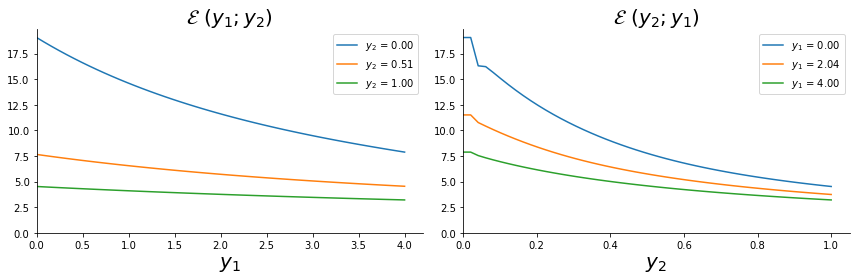

In [38]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat[:,0], ems[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat[:,0], ems[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}\ (y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(y2_mat[0], ems[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[10], ems[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.plot(y2_mat[-1], ems[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$\mathcal{E}\ ( y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
ax2.legend()
# ax2.set_ylim(0,12)
fig.tight_layout()
# plt.savefig("E.png", bbox_inches="tight", facecolor="w", edgecolor="w")

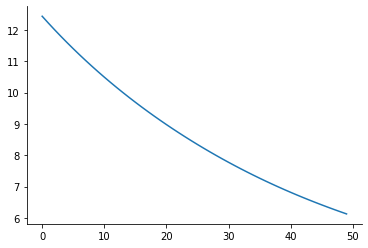

In [39]:
plt.plot(ems[:,10])

In [82]:
from scipy import interpolate
def simualte_ems(y1_grid, y2_grid, ems, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
    Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp2d(y2_grid, y1_grid, ems, )
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y2, y1)
        ems_t[t] = ems_point[0]
        Y1t[t] = y1
        Y2t[t] = y2
        y1 += y2*dt
        y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, Y2t, ems_t

In [83]:
Y1t,Y2t, Et = simualte_ems(y1_grid, y2_grid, ems, dt=1/4)

In [84]:
ems[13,0], Et[0], Et[6*4]

(14.394666868609265, 16.433837579765687, 16.185684748950184)

In [85]:
Et.shape, np.arange(0,100,1/4).shape

((400,), (400,))

(0.0, 16.756955915815453)

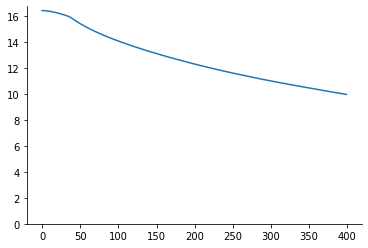

In [86]:
plt.plot(Et)
plt.ylim(0)

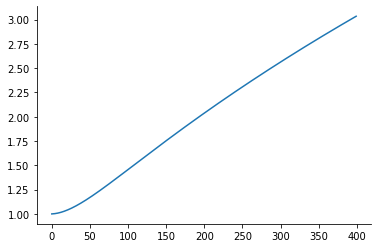

In [52]:
plt.plot(Y1t)

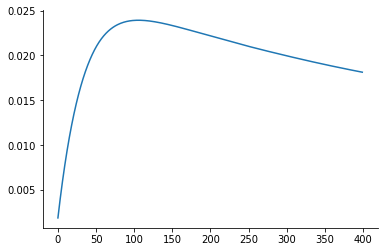

In [53]:
plt.plot(Y2t)

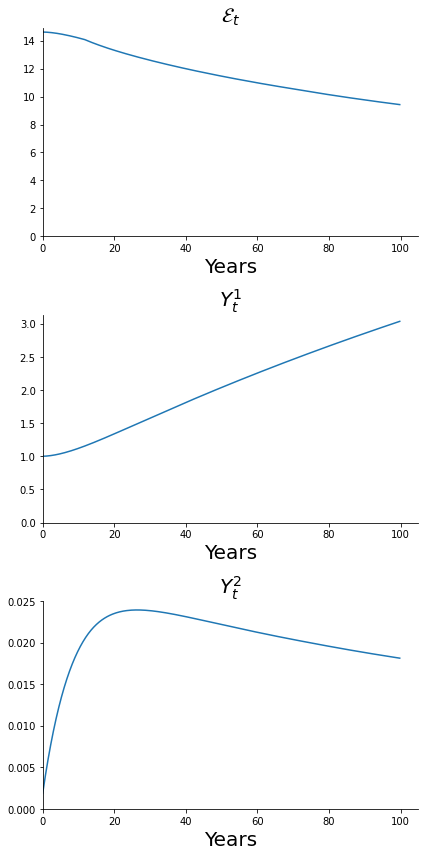

In [54]:
years = np.arange(0,100, 1/4)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6,12))
ax1.plot(years, Et)
# ax1.plot(y1_mat[:,0], ems[:,49], label="$y_2$ = {:.2f}".format(y2_mat[0,49]))
# ax1.plot(y1_mat[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}_t$', size=20)
ax1.set_xlabel("Years", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
# ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(years, Y1t, label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.set_title('$Y^1_t$', size=20)
ax2.set_xlabel('Years', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
# ax2.legend()
# ax2.set_ylim(0,12)

ax3.plot(years, Y2t)
ax3.set_title('$Y_t^2$', size=20)
ax3.set_xlabel('Years', size=20)
ax3.set_ylim(0)
ax3.set_xlim(0)
fig.tight_layout()
# plt.savefig("simulation.png", bbox_inches="tight", facecolor="w", edgecolor="w")

In [55]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [56]:
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0085
κ = 6.667
k0 = 80/α

In [94]:
Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0, dt=1/4)
MC = δ*(1-η)/((α - invkap)*np.exp(Kt))
scc = η*(α - invkap)*np.exp(Kt)/(1-η)/Et*1000

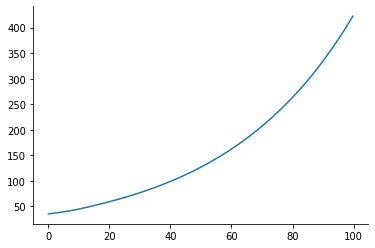

In [95]:
plt.plot(years, scc)

In [69]:
# ξₘ is 1000, no ambiguity over damage
numy_bar = 50
y_min = 0
y_max = 4
hy = (ȳ - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)
ς = 0.1
ξa = 1000
ξw = 1000
ξp = 1/20
γ3 = 0
σy = 1e-3
args = (δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξa, ξw)
ϕ_1d, ems_1d, π_1d,  h_1d = solve_smooth(y1_grid, args,  max_iter=5_000, tol=1e-7, ϵ=1)

episode: 782,	 ode error: 2.5108980126304584e-06,	 ft error: 9.95397175657109e-08


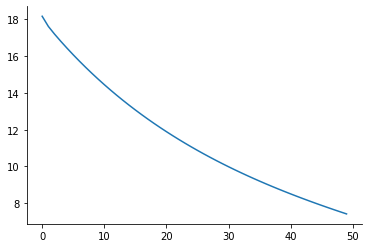

In [70]:
plt.plot(ems_1d)

In [79]:
def simualte_ems_1d(y1_grid, ems_1d, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
#     Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp1d(y1_grid, ems_1d,)
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y1)
        ems_t[t] = ems_point
        Y1t[t] = y1
#         Y2t[t] = y2
        y1 += ems_point*θ*dt
#         y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, ems_t

In [80]:
y1_1d, et_1d = simualte_ems_1d(y1_grid, ems_1d, dt=1/4)

(0.0, 20.0)

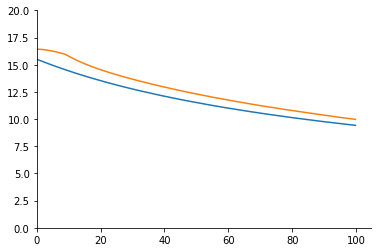

In [90]:
plt.plot(years, et_1d)
plt.plot(years, Et)
plt.xlim(0)
plt.ylim(0, 20)

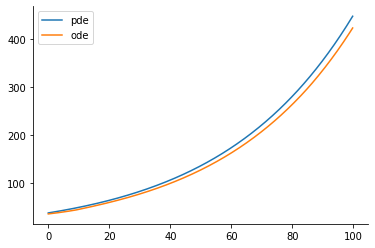

In [100]:
scc_1d =  η*(α - invkap)*np.exp(Kt)/(1-η)/et_1d*1000
plt.plot(years, scc_1d, label="pde")
plt.plot(years, scc, label="ode")
plt.legend()